### [Regression Data Analysis]
# KaKR House Price Prediction - Expensive House & Residual Analisys

- RMSE에 큰 영향을 미치는 비싼 가격의 집에 대해 분석


- 잔차 정규성 및 잔차의 분포 분석

---

#### Import Modules

In [228]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor, plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from scipy.stats import skew

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
row_data = pd.read_csv("./data/train.csv", index_col=['id'])
row_test = pd.read_csv("./data/test.csv", index_col=['id'])

row_data.shape, row_test.shape

((15035, 20), (6468, 19))

## Features Preprocessing function

In [3]:
def feature_preprocess(row_data, zipcode_rank_dict):
    
    data = row_data.copy()
    
    # price log transformation
    if 'price' in data.columns:
        data['log_price'] = np.log1p(data.price)
    
    # Date parsing
    data['date'] = data['date'].apply(lambda i: i[:8])
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data.date.dt.year
    data['month'] = data.date.dt.month
    data['day']= data.date.dt.day
    data['year_month'] = data.date.dt.year * 100 + data.date.dt.month
    data['day_of_week'] = data.date.dt.dayofweek
    data['2015_or_not'] = data.year.apply(lambda i: 0 if i == 2014 else 1)
    data['weekday_ohe'] = data.day_of_week.apply(lambda i: 1 if i in range(5) else 0)
    data['saturday_ohe'] = data.day_of_week.apply(lambda i: 1 if i == 5 else 0)
    data['sunday_ohe'] = data.day_of_week.apply(lambda i: 1 if i == 6 else 0)
    
    # yr_renovated
    data['yr_renovated_ohe'] = data['yr_renovated'].apply(lambda i: 0 if i == 0 else 1)
    
    # zipcode : 위에서 zipcode_rank_dict를 만들어놔야 코드가 실행됨
    data['zipcode_rank'] = 71 - data['zipcode'].apply(lambda i: zipcode_rank_dict[i])
    
    # lat / long
    data['lat_scale'] = (data['lat'] - data['lat'].mean()) / data['lat'].std()
    data['long_scale'] = (data['long'] - data['long'].mean()) / data['long'].std()
    
    # areas
    data['sqft_living_scale'] = np.log1p(data['sqft_living'])
    data['sqft_lot_scale'] = np.log1p(data['sqft_lot'])
    data['sqft_living_diff'] = data['sqft_living15'] - data['sqft_living']
    data['sqft_lot_diff'] = data['sqft_lot15'] - data['sqft_lot']
    data.loc[data['sqft_living_diff'] < 0, 'sqft_living_diff_scale'] = -np.log1p(-data['sqft_living_diff'])
    data.loc[data['sqft_living_diff'] >= 0, 'sqft_living_diff_scale'] = np.log1p(data['sqft_living_diff'])
    data.loc[data['sqft_lot_diff'] < 0, 'sqft_lot_diff_scale'] = -np.log1p(-data['sqft_lot_diff'])
    data.loc[data['sqft_lot_diff'] >= 0, 'sqft_lot_diff_scale'] = np.log1p(data['sqft_lot_diff'])
    data['sqft_above_scale'] = np.log1p(data['sqft_above'])
    data['sqft_basement_ohe'] = data.sqft_basement.apply(lambda i: 0 if i == 0 else 1)
    
    return data

def get_ziprank(data):
    zipcode_rank = data.groupby(['zipcode']).mean().sort_values(by=['price'], \
                                                                ascending=False).reset_index()[['zipcode', 'price']]
    zipcode_rank['rank'] = range(1, len(zipcode_rank)+1)
    zipcode_rank_dict = zipcode_rank.set_index(['zipcode'])['rank'].to_dict()
    
    return zipcode_rank_dict

In [4]:
zipcode_rank_dict = get_ziprank(row_data)

data = feature_preprocess(row_data, zipcode_rank_dict)
test = feature_preprocess(row_test, zipcode_rank_dict)

data.shape, test.shape

((15035, 42), (6468, 40))

In [5]:
def transform_skewness(data):
    
    data_skew = data.copy()
    
    data_skew['year_month_scale'] = (data['year_month'] - data.year_month.min()) \
                                / (data.year_month.max() - data.year_month.min())
    data_skew['bedrooms_scale'] = np.log1p(data.bedrooms)
    data_skew['bathrooms_scale'] = np.log1p(data.bathrooms)
    data_skew['floors_scale'] = np.log1p(data.floors)
    data_skew['grade_scale'] = np.exp((data['grade'] - data.grade.min()) \
                                 / (data.grade.max() - data.grade.min()))
    data_skew['zipcode_rank_scale'] = np.exp((data['zipcode_rank'] - data.zipcode_rank.min()) \
                                        / (data.zipcode_rank.max() - data.zipcode_rank.min()))
    
    return data_skew

In [6]:
data = transform_skewness(data)
test = transform_skewness(test)

## Evaluation functions

In [247]:
def rmsle_cv(model, train, label):
    rmse_list = np.sqrt(-cross_val_score(model, train, label, scoring='neg_mean_squared_error', cv=5))
    
    return np.round(np.mean(rmse_list), 4)

def r2_cv(model, train, label):
    r2_list = cross_val_score(model, train, label, scoring='r2', cv=5)
    
    return np.round(np.mean(r2_list), 4)

def rmse(model, y_test, y_pred):

    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

def get_scores(models, train, label, rmse_=True):
    df = {}
    
    for idx, model in enumerate(models):
#         model_name = model.__class__.__name__
        model_name = idx + 1
        df[model_name] = []
        df[model_name].append(rmsle_cv(model, train, label))
        df[model_name].append(r2_cv(model, train, label))
        
        if rmse_:
            X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            df[model_name].append(rmse(model, y_test, y_pred))
        
        if rmse_:
            score_df = pd.DataFrame(df, index=['RMSLE', 'R2 score', 'RMSE']).T.sort_values('R2 score', \
                                                                                           ascending=False)
        else:
            score_df = pd.DataFrame(df, index=['RMSLE', 'R2 score']).T.sort_values('R2 score', \
                                                                                   ascending=False)
            
    return score_df

## Coefficient

In [8]:
def get_coef(models, sort_model):
    coef = {}
    
    for model in models:
        model_name = model.__class__.__name__
        coef[model_name] = model.coef_

    coef_df = pd.DataFrame(coef, index=train.columns)
    
    return coef_df.sort_values(sort_model.__class__.__name__, ascending=False)

def draw_coefs(models):
    if len(models) == 3:
        figure, axs = plt.subplots(nrows=1, ncols=3)
        figure.set_size_inches(18, 6)

        for idx, model in enumerate(models):
            model_name = model.__class__.__name__
            sns.barplot(x=get_coef(models, model)[model_name].values, \
                        y=get_coef(models, model)[model_name].index, \
                        ax=axs[idx]).set_title(model_name)
    else:
        figure, axs = plt.subplots(nrows=2, ncols=2)
        figure.set_size_inches(18, 12)

        for idx, model in enumerate(models):
            model_name = model.__class__.__name__
            sns.barplot(x=get_coef(models, model)[model_name].values, \
                        y=get_coef(models, model)[model_name].index, \
                        ax=axs[idx//2][idx%2]).set_title(model_name)
    
    plt.show()

def draw_importances(models, data):
    if type(models) != list:
        model = models
        model_name = model.__class__.__name__
        importances = [i for i in zip(data.columns, model.feature_importances_)]
        importances = sorted([[i[0], float(i[1])] for i in importances], key=lambda i: i[1], reverse=True)
        plt.figure(figsize=(8, 6))
        sns.barplot(x=[i[1] for i in importances], y=[i[0] for i in importances]).set_title(model_name)
    
    elif len(models) == 3:
        figure, axs = plt.subplots(nrows=1, ncols=3)
        figure.set_size_inches(18, 6)

        for idx, model in enumerate(models):
            model_name = model.__class__.__name__
            importances = [i for i in zip(train.columns, model.feature_importances_)]
            importances = sorted([[i[0], float(i[1])] for i in importances], key=lambda i: i[1], reverse=True)
            sns.barplot(x=[i[1] for i in importances], y=[i[0] for i in importances], \
                        ax=axs[idx]).set_title(model_name)

    else:
        figure, axs = plt.subplots(nrows=2, ncols=2)
        figure.set_size_inches(18, 12)

        for idx, model in enumerate(models):
            model_name = model.__class__.__name__
            importances = [i for i in zip(train.columns, model.feature_importances_)]
            importances = sorted([[i[0], float(i[1])] for i in importances], key=lambda i: i[1], reverse=True)
            sns.barplot(x=[i[1] for i in importances], y=[i[0] for i in importances], \
                        ax=axs[idx//2][idx%2]).set_title(model_name)

    plt.show()

## Blending Models

In [9]:
def BlendingModels(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

## Submission File

In [10]:
def LetSubmit(y_pred, filename):
    submission = pd.read_csv("./data/sample_submission.csv")
    submission['price'] = y_pred
    submission.to_csv("./submission/{}.csv".format(filename), index_label=False, index=False)
    submission_test = pd.read_csv("./submission/{}.csv".format(filename))
    
    return submission_test

## Get Best Parameters

In [11]:
def BestParamsGrid(model, train, label, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, label)
    rmsle = np.sqrt(-1 * grid_model.best_score_)
    params_df = pd.DataFrame(grid_model.best_params_, index=[grid_model.__class__.__name__]).T

    return grid_model, grid_model.best_params_, rmsle

def CoarseSearch(train, label, model_name='lgbm', num_epoch=100):
    params_list = []
    
    start_time = datetime.now()
    print("Let's start\t\t\t\t")
    
    for epoch in range(1, num_epoch+1):
        n_estimators = np.random.randint(low=100, high=1000)
        max_depth = np.random.randint(low=2, high=100)
        learning_rate = 10 ** -np.random.uniform(low=0, high=10)
        subsample = np.random.uniform(low=0.4, high=1.0)
        colsample_bytree = np.random.uniform(low=0.4, high=1.0)
        colsample_bylevel = np.random.uniform(low=0.4, high=1.0)
        num_leaves = np.random.randint(low=5, high=1000)
        min_child_samples = np.random.randint(low=50, high=2000)
        
        if model_name == 'lgbm':
            model = LGBMRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  learning_rate=learning_rate,
                                  subsample=subsample,
                                  colsample_bylevel=colsample_bylevel,
                                  colsample_bytree=colsample_bytree,
                                  num_leaves=num_leaves,
                                  min_child_samples=min_child_samples,
                                  seed=37)
            
        elif model_name == 'xgb':
            model = XGBRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 learning_rate=learning_rate,
                                 subsample=subsample,
                                 colsample_bylevel=colsample_bylevel,
                                 colsample_bytree=colsample_bytree,
                                 seed=37)

        score = np.sqrt(-cross_val_score(model, train, label, cv=8, scoring='neg_mean_squared_error').mean())

        params = {
            'epoch': epoch,
            'score': score,
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'subsample': subsample,
            'colsample_bylevel': colsample_bylevel,
            'colsample_bytree': colsample_bytree,
            'num_leaves': num_leaves,
            'min_child_samples': min_child_samples,
        }

        params_list.append(params)
        
        if (epoch == 1) | (epoch % (num_epoch//10) == 0):
            print("{} epoch is now calculating . . .\t".format(epoch), str(datetime.now() - start_time)[:-7])
            
    finish_time = datetime.now()
    print("All Coarse Searching is Finished")
    print("All taken:", str(finish_time - start_time)[:-7])

    params_df = pd.DataFrame.from_dict(params_list).sort_values('score')
    print(params_df.shape)
    
    return params_df

def BestParamsGrid(model, train, label, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, label)
    rmsle = np.sqrt(-1 * grid_model.best_score_)
    params_df = pd.DataFrame(grid_model.best_params_, index=[grid_model.__class__.__name__]).T

    return grid_model, grid_model.best_params_, rmsle

def CoarseSearch(train, label, model_name='lgbm', num_epoch=100):
    params_list = []
    
    start_time = datetime.now()
    print("Let's start\t\t\t\t")
    
    for epoch in range(1, num_epoch+1):
        n_estimators = np.random.randint(low=100, high=1000)
        max_depth = np.random.randint(low=2, high=100)
        learning_rate = 10 ** -np.random.uniform(low=0, high=10)
        subsample = np.random.uniform(low=0.4, high=1.0)
        colsample_bytree = np.random.uniform(low=0.4, high=1.0)
        colsample_bylevel = np.random.uniform(low=0.4, high=1.0)
        num_leaves = np.random.randint(low=5, high=1000)
        min_child_samples = np.random.randint(low=50, high=2000)
        
        if model_name == 'lgbm':
            model = LGBMRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  learning_rate=learning_rate,
                                  subsample=subsample,
                                  colsample_bylevel=colsample_bylevel,
                                  colsample_bytree=colsample_bytree,
                                  num_leaves=num_leaves,
                                  min_child_samples=min_child_samples,
                                  seed=37)
            
        elif model_name == 'xgb':
            model = XGBRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 learning_rate=learning_rate,
                                 subsample=subsample,
                                 colsample_bylevel=colsample_bylevel,
                                 colsample_bytree=colsample_bytree,
                                 seed=37)

        score = np.sqrt(-cross_val_score(model, train, label, cv=8, scoring='neg_mean_squared_error').mean())

        params = {
            'epoch': epoch,
            'score': score,
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'subsample': subsample,
            'colsample_bylevel': colsample_bylevel,
            'colsample_bytree': colsample_bytree,
            'num_leaves': num_leaves,
            'min_child_samples': min_child_samples,
        }

        params_list.append(params)
        
        if (epoch == 1) | (epoch % (num_epoch//10) == 0):
            print("{} epoch is now calculating . . .\t".format(epoch), str(datetime.now() - start_time)[:-7])
            
    finish_time = datetime.now()
    print("All Coarse Searching is Finished")
    print("All taken:", str(finish_time - start_time)[:-7])

    params_df = pd.DataFrame.from_dict(params_list).sort_values('score')
    print(params_df.shape)
    
    return params_df

def FinerSearch(train, label, param_range, model_name='lgbm', num_epoch=100):
    params_list = []
    
    start_time = datetime.now()
    print("Let's start\t\t\t\t")
    
    for epoch in range(1, num_epoch+1):
        n_estimators = np.random.randint(low=param_range['n_estimators'][0], \
                                         high=param_range['n_estimators'][1])
        max_depth = np.random.randint(low=param_range['max_depth'][0], \
                                      high=param_range['max_depth'][1])
        learning_rate = np.random.uniform(low=param_range['learning_rate'][0], \
                                          high=param_range['learning_rate'][1])
#         subsample = np.random.uniform(low=param_range['subsample'][0], \
#                                       high=param_range['subsample'][1])
#         colsample_bytree = np.random.uniform(low=param_range['colsample_bytree'][0], \
#                                              high=param_range['colsample_bytree'][1])
#         colsample_bylevel = np.random.uniform(low=param_range['colsample_bylevel'][0], \
#                                               high=param_range['colsample_bylevel'][1])
#         num_leaves = np.random.randint(low=param_range['num_leaves'][0], \
#                                        high=param_range['num_leaves'][1])
#         min_child_samples = np.random.randint(low=param_range['min_child_samples'][0], \
#                                               high=param_range['min_child_samples'][1])
        
        if model_name == 'lgbm':
            model = LGBMRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  learning_rate=learning_rate,
#                                   subsample=subsample,
#                                   colsample_bylevel=colsample_bylevel,
#                                   colsample_bytree=colsample_bytree,
#                                   num_leaves=num_leaves,
#                                   min_child_samples=min_child_samples,
                                  seed=37)
            
            score = np.sqrt(-cross_val_score(model, train, label, cv=8, \
                                             scoring='neg_mean_squared_error', n_jobs=5).mean())

            params = {
                'epoch': epoch,
                'score': score,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'learning_rate': learning_rate,
#                 'subsample': subsample,
#                 'colsample_bylevel': colsample_bylevel,
#                 'colsample_bytree': colsample_bytree,
#                 'num_leaves': num_leaves,
#                 'min_child_samples': min_child_samples,
            }
            
        elif model_name == 'xgb':
            model = XGBRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 learning_rate=learning_rate,
                                 seed=37)

            score = np.sqrt(-cross_val_score(model, train, label, cv=8, \
                                             scoring='neg_mean_squared_error', n_jobs=5).mean())

            params = {
                'epoch': epoch,
                'score': score,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'learning_rate': learning_rate,
            }

        params_list.append(params)
        
        if (epoch == 1) | (epoch % (num_epoch//10) == 0):
            print("{} epoch is now calculating . . .\t".format(epoch), str(datetime.now() - start_time)[:-7])
            
    finish_time = datetime.now()
    print("All Coarse Searching is Finished")
    print("time duration:", str(finish_time - start_time)[:-7])

    params_df = pd.DataFrame.from_dict(params_list).sort_values('score')
    print(params_df.shape)
    
    return params_df

## Train / Label data

In [12]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
            'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_month']

train = data[features]
data['log_price'] = np.log1p(data.price)
label = data['log_price']

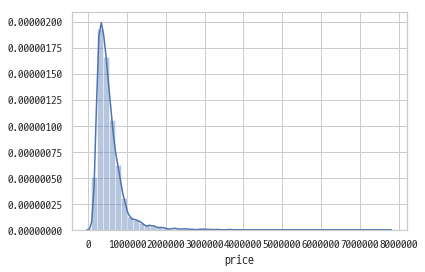

In [15]:
sns.distplot(data['price'])
plt.show()

## Bias : residual

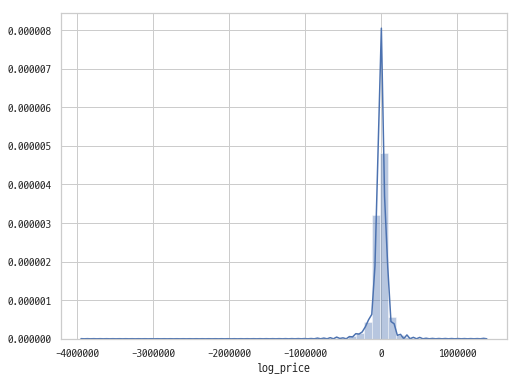

In [171]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)

lgbm = LGBMRegressor(n_estimators=900,
                     max_depth=7,
                     learning_rate=0.035)

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)

residual = y_pred - y_test

plt.figure(figsize=(8, 6))
sns.distplot(residual)
plt.show()

In [172]:
predict_df = pd.DataFrame(np.array([y_pred, y_test, residual]).T, columns=['y_pred', 'y_test', 'residual'])
print(predict_df.shape)
predict_df.head()

(3007, 3)


,y_pred,y_test,residual
0,367685.108765,343500.0,24185.108765
1,273627.687328,285000.0,-11372.312672
2,306152.449025,272000.0,34152.449025
3,287369.243294,280927.0,6442.243294
4,248531.281056,253500.0,-4968.718944


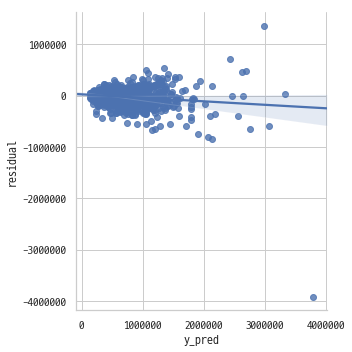

In [176]:
sns.lmplot(data=predict_df, x='y_pred', y='residual')
plt.show()

In [113]:
predict_df.describe()

,y_pred,y_test,residual
count,3.007000e+03,3.007000e+03,3.007000e+03
mean,5.331007e+05,5.407512e+05,-7.650529e+03
std,3.457337e+05,3.680599e+05,1.133361e+05
min,1.277322e+05,8.100000e+04,-1.463536e+06
25%,3.213516e+05,3.249750e+05,-3.887414e+04
50%,4.529322e+05,4.500000e+05,-3.486870e+03
75%,6.320069e+05,6.474000e+05,3.299791e+04
max,5.520623e+06,5.570000e+06,8.042472e+05


## LGBM Bias

In [294]:
%%time
residual_total = []
y_pred_total = []
y_test_total = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)

    lgbm = LGBMRegressor(n_estimators=900,
                         max_depth=7,
                         learning_rate=0.035)

    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)

    y_pred = np.expm1(y_pred)
    y_test = np.expm1(y_test)

    residual = y_pred - y_test
    
    y_test_total.append(y_test.values)
    y_pred_total.append(y_pred)
    residual_total.append(residual.values)
    
    if i % 10 == 0:
        print("{} epoch running . . ".format(i))

0 epoch running . . 
10 epoch running . . 
20 epoch running . . 
30 epoch running . . 
40 epoch running . . 
50 epoch running . . 
60 epoch running . . 
70 epoch running . . 
80 epoch running . . 
90 epoch running . . 
CPU times: user 14min 21s, sys: 6.65 s, total: 14min 28s
Wall time: 1min 13s


In [295]:
len(residual_total[0])

3007

In [296]:
residual_total_mean = np.mean(residual_total, axis=0)
len(residual_total_mean)

3007

In [297]:
np.mean(residual_total_mean)

-7272.7938400807825

- LGBM bias : `-7259`

### 1000000 이상의 집들의 residual의 평균

## Big Residual

In [298]:
low_bound_mean = 0
high_bound_mean = 0
qualtile_weight = 1.5

for i in range(len(residual_total)):
    low_qualtile = np.percentile(residual_total[i], 25)
    high_qualtile = np.percentile(residual_total[i], 75)
    inter_qualtile = high_qualtile - low_qualtile
    
    low_bound = low_qualtile - qualtile_weight * inter_qualtile
    high_bound = high_qualtile + qualtile_weight * inter_qualtile
    
    low_bound_mean += low_bound
    high_bound_mean += high_bound
    
low_bound_mean /= len(residual_total)
high_bound_mean /= len(residual_total)
    
print(low_bound_mean, '\t', high_bound_mean)

-145985.9227247642 	 142170.31901176847


In [299]:
bound = (high_bound_mean + (-low_bound_mean)) / 2
bound

144078.12086826633

In [300]:
big_residual = predict_df[np.abs(predict_df['residual']) > bound]
print(big_residual.shape)
big_residual.head()

(275, 3)


,y_pred,y_test,residual
7,773307.506370,1050000.0,-276692.493630
20,748018.081753,925000.0,-176981.918247
38,267955.803995,475000.0,-207044.196005
45,515161.437756,704000.0,-188838.562244
75,741009.155170,577288.0,163721.155170


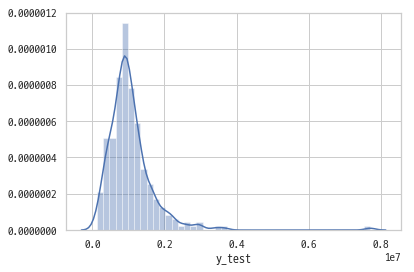

In [301]:
sns.distplot(big_residual['y_test'])
plt.show()

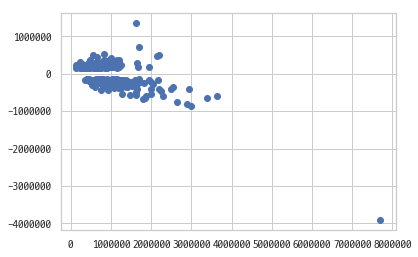

In [302]:
plt.scatter(x=big_residual['y_test'], y=big_residual['residual'])
plt.show()

In [303]:
big_residual.describe()

,y_pred,y_test,residual
count,2.750000e+02,2.750000e+02,2.750000e+02
mean,9.599640e+05,1.060768e+06,-1.008044e+05
std,5.230489e+05,6.823333e+05,3.647302e+05
min,1.912641e+05,1.300000e+05,-3.920248e+06
25%,6.062145e+05,6.965000e+05,-2.508244e+05
50%,8.673776e+05,9.500000e+05,-1.799531e+05
75%,1.175304e+06,1.260750e+06,1.687214e+05
max,3.779752e+06,7.700000e+06,1.359541e+06


- 평균 `1,094,793` 가격대의 집들을 엄청 틀림

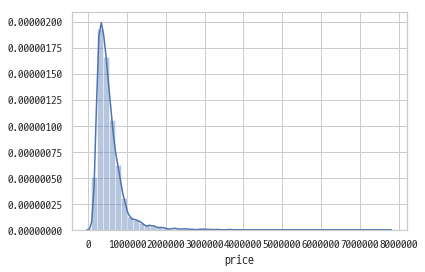

In [134]:
sns.distplot(data['price'])
plt.show()

In [138]:
data['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

- 원래 데이터 평균은 `540,682`

## High Price House

(1018, 48)


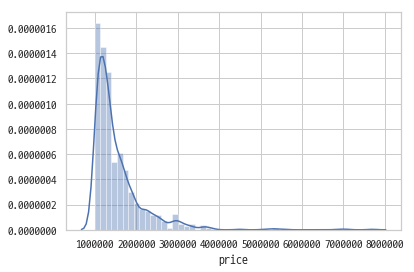

In [304]:
high_price = data[data['price'] > 1000000]
print(high_price.shape)
sns.distplot(high_price['price'])
plt.show()

In [158]:
train_hp = high_price[features]
label_hp = high_price['log_price']

X_train, X_test, y_train, y_test = train_test_split(train_hp, label_hp, test_size=0.2)

lgbm_high = LGBMRegressor()
lgbm_high.fit(X_train, y_train)
y_pred = lgbm_high.predict(X_test)

np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test)))

331100.2765915379

## XGB Bias

In [16]:
%%time
residual_total = []
y_pred_total = []
y_test_total = []
num_epoch = 500

for i in range(num_epoch):
    X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)

    xgb = XGBRegressor(n_estimators=793,
                       max_depth=7,
                       learning_rate=0.03939)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    y_pred = np.expm1(y_pred)
    y_test = np.expm1(y_test)

    residual = y_pred - y_test
    
    y_test_total.append(y_test.values)
    y_pred_total.append(y_pred)
    residual_total.append(residual.values)
    
    if i % (num_epoch//10) == 0:
        print("{} epoch running . . ".format(i))

0 epoch running . . 
50 epoch running . . 
100 epoch running . . 
150 epoch running . . 
200 epoch running . . 
250 epoch running . . 
300 epoch running . . 
350 epoch running . . 
400 epoch running . . 
450 epoch running . . 
CPU times: user 2h 1min 18s, sys: 1.78 s, total: 2h 1min 20s
Wall time: 2h 1min 20s


In [17]:
len(residual_total[0])

3007

In [18]:
residual_total_mean = np.mean(residual_total, axis=0)
len(residual_total_mean)

3007

In [19]:
np.mean(residual_total_mean)

-8132.662342804303

- bias로 생각 가능

---
---

In [20]:
X_sub = test[features]

## XGB best model

In [21]:
xgb = XGBRegressor(n_estimators=793,
                   max_depth=7,
                   learning_rate=0.03939)

In [22]:
xgb.fit(train, label)
y_pred = xgb.predict(X_sub)
y_pred

array([13.168792, 13.01605 , 14.110845, ..., 13.082218, 12.68552 ,
       13.031048], dtype=float32)

In [51]:
submission = LetSubmit(np.expm1(y_pred), "xgb_test")
submission.head()

,id,price
0,15035,4.942906e+05
1,15036,4.744508e+05
2,15037,1.256917e+06
3,15038,3.068664e+05
4,15039,2.861011e+05


> Submission : 107718

### Bias 더하기 : ( 8132 )

In [23]:
xgb = XGBRegressor(n_estimators=793,
                   max_depth=7,
                   learning_rate=0.03939)

In [24]:
%%time
xgb.fit(train, label)
y_pred = xgb.predict(X_sub)
y_pred

CPU times: user 19 s, sys: 17.5 ms, total: 19 s
Wall time: 19 s


In [25]:
y_pred = np.expm1(y_pred) + 8132
y_pred

array([ 531892.5 ,  457702.56, 1351706.1 , ...,  488455.97,  331167.38,
        464495.8 ], dtype=float32)

In [26]:
submission = LetSubmit(y_pred, "tune_xgb_bias")
submission.head()

,id,price
0,15035,531892.50
1,15036,457702.56
2,15037,1351706.10
3,15038,309375.60
4,15039,335234.03


> Submission : 107346

- 확인

In [32]:
np.sqrt(107718 ** 2 - 8132 * 6468)

107473.57697592465

---

### y_pred로 residual을 예측해보자

In [119]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
            'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_month']

train = data[features]
data['log_price'] = np.log1p(data.price)
label = data['log_price']

print(train.shape, label.shape)

(15035, 19) (15035,)


In [124]:
%%time
xgb_residual_total = []
xgb_y_pred_total = []
lgbm_residual_total = []
lgbm_y_pred_total = []
y_true_total = []
num_epoch = 100

for i in range(num_epoch):
    X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)

    xgb = XGBRegressor(n_estimators=793,
                       max_depth=7,
                       learning_rate=0.03939)

    lgbm = LGBMRegressor(n_estimators=900,
                         max_depth=7,
                         learning_rate=0.035)

    xgb.fit(X_train, y_train)
    xgb_y_pred = xgb.predict(X_test)
    xgb_y_pred = np.expm1(xgb_y_pred)
    xgb_y_pred_total.append(xgb_y_pred)

    lgbm.fit(X_train, y_train)
    lgbm_y_pred = lgbm.predict(X_test)
    lgbm_y_pred = np.expm1(lgbm_y_pred)
    lgbm_y_pred_total.append(lgbm_y_pred)
    
    y_test = np.expm1(y_test)
    
    xgb_residual = xgb_y_pred - y_test
    lgbm_residual = lgbm_y_pred - y_test
    xgb_residual_total.append(xgb_residual.values)
    lgbm_residual_total.append(lgbm_residual.values)
    
    y_true_total.append(y_test.values)
    
    if i % (num_epoch//10) == 0:
        print("{} epoch running . . ".format(i))

0 epoch running . . 
10 epoch running . . 
20 epoch running . . 
30 epoch running . . 
40 epoch running . . 
50 epoch running . . 
60 epoch running . . 
70 epoch running . . 
80 epoch running . . 
90 epoch running . . 
CPU times: user 44min 32s, sys: 18.9 s, total: 44min 51s
Wall time: 27min 20s


In [125]:
y_true_df = pd.DataFrame(y_true_total)
print(y_true_df.shape)

(100, 3007)


In [126]:
xgb_y_pred_df = pd.DataFrame(xgb_y_pred_total)
lgbm_y_pred_df = pd.DataFrame(lgbm_y_pred_total)
print(xgb_y_pred_df.shape, lgbm_y_pred_df.shape)

(100, 3007) (100, 3007)


In [127]:
xgb_resid_df = pd.DataFrame(xgb_residual_total)
lgbm_resid_df = pd.DataFrame(lgbm_residual_total)
print(xgb_resid_df.shape, lgbm_resid_df.shape)

(100, 3007) (100, 3007)


#### long_true 만들기

In [128]:
long_true = pd.DataFrame()

for col in y_true_df.columns:
    long_true = pd.concat([long_true, y_true_df[col]])

In [129]:
long_true = long_true.reset_index(drop=True)
long_true = long_true.rename(columns={0: 'y_true'})
print(long_true.shape)
long_true.tail()

(300700, 1)


,y_true
300695,269500.0
300696,245000.0
300697,535000.0
300698,518000.0
300699,369950.0


#### long_pred 만들기

In [130]:
xgb_long_pred = pd.DataFrame()

for col in xgb_y_pred_df.columns:
    xgb_long_pred = pd.concat([xgb_long_pred, xgb_y_pred_df[col]])

In [131]:
lgbm_long_pred = pd.DataFrame()

for col in lgbm_y_pred_df.columns:
    lgbm_long_pred = pd.concat([lgbm_long_pred, lgbm_y_pred_df[col]])

In [132]:
xgb_long_pred = xgb_long_pred.reset_index(drop=True)
xgb_long_pred = xgb_long_pred.rename(columns={0: 'xgb_y_pred'})
print(xgb_long_pred.shape)
xgb_long_pred.head()

(300700, 1)


,xgb_y_pred
0,726184.437500
1,985607.875000
2,207045.921875
3,517096.031250
4,715452.500000


In [133]:
lgbm_long_pred = lgbm_long_pred.reset_index(drop=True)
lgbm_long_pred = lgbm_long_pred.rename(columns={0: 'lgbm_y_pred'})
print(lgbm_long_pred.shape)
lgbm_long_pred.head()

(300700, 1)


,lgbm_y_pred
0,7.572022e+05
1,1.084701e+06
2,2.061704e+05
3,5.180918e+05
4,7.468535e+05


#### long_resid 만들기

In [138]:
xgb_long_resid = pd.DataFrame()

for col in xgb_resid_df.columns:
    xgb_long_resid = pd.concat([xgb_long_resid, xgb_resid_df[col]])

In [139]:
lgbm_long_resid = pd.DataFrame()

for col in lgbm_resid_df.columns:
    lgbm_long_resid = pd.concat([lgbm_long_resid, lgbm_resid_df[col]])

In [140]:
xgb_long_resid = xgb_long_resid.reset_index(drop=True)
xgb_long_resid = xgb_long_resid.rename(columns={0: 'xgb_residual'})
print(xgb_long_resid.shape)
xgb_long_resid.tail()

(300700, 1)


,xgb_residual
300695,-13118.00000
300696,-19405.68750
300697,70172.56250
300698,132452.81250
300699,-44021.28125


In [141]:
lgbm_long_resid = lgbm_long_resid.reset_index(drop=True)
lgbm_long_resid = lgbm_long_resid.rename(columns={0: 'lgbm_residual'})
print(lgbm_long_resid.shape)
lgbm_long_resid.tail()

(300700, 1)


,lgbm_residual
300695,-17904.584980
300696,-8668.534570
300697,71445.790631
300698,144145.991445
300699,-43293.944748


#### 셋 합치기

In [143]:
print(long_true.shape)
print(xgb_long_pred.shape)
print(lgbm_long_pred.shape)
print(xgb_long_resid.shape)
print(lgbm_long_resid.shape)

(300700, 1)
(300700, 1)
(300700, 1)
(300700, 1)
(300700, 1)


In [148]:
meta_data = pd.DataFrame(columns=['y_true', 'xgb_y_pred', 'lgbm_y_pred', 'xgb_residual', 'lgbm_residual'])
meta_data['y_true'] = long_true['y_true'].values
meta_data['xgb_y_pred'] = xgb_long_pred['xgb_y_pred'].values
meta_data['lgbm_y_pred'] = lgbm_long_pred['lgbm_y_pred'].values
meta_data['xgb_residual'] = xgb_long_resid['xgb_residual'].values
meta_data['lgbm_residual'] = lgbm_long_resid['lgbm_residual'].values
print(meta_data.shape)
meta_data.tail()

(300700, 5)


,y_true,xgb_y_pred,lgbm_y_pred,xgb_residual,lgbm_residual
300695,269500.0,256382.00000,251595.415020,-13118.00000,-17904.584980
300696,245000.0,225594.31250,236331.465430,-19405.68750,-8668.534570
300697,535000.0,605172.56250,606445.790631,70172.56250,71445.790631
300698,518000.0,650452.81250,662145.991445,132452.81250,144145.991445
300699,369950.0,325928.71875,326656.055252,-44021.28125,-43293.944748


In [149]:
meta_data['mean_residual'] = (meta_data.xgb_residual + meta_data.lgbm_residual) / 2
meta_data.tail()

,y_true,xgb_y_pred,lgbm_y_pred,xgb_residual,lgbm_residual,mean_residual
300695,269500.0,256382.00000,251595.415020,-13118.00000,-17904.584980,-15511.292490
300696,245000.0,225594.31250,236331.465430,-19405.68750,-8668.534570,-14037.111035
300697,535000.0,605172.56250,606445.790631,70172.56250,71445.790631,70809.176566
300698,518000.0,650452.81250,662145.991445,132452.81250,144145.991445,138299.401972
300699,369950.0,325928.71875,326656.055252,-44021.28125,-43293.944748,-43657.612999


In [266]:
print(len(meta_data[meta_data['mean_residual'] < 0]))
print(len(meta_data[meta_data['mean_residual'] > 0]))

156161
144539


### 1000000 이상의 집들의 residual의 평균

In [325]:
meta_data.describe()

,y_true,xgb_y_pred,lgbm_y_pred,xgb_residual,lgbm_residual,mean_residual
count,3.007000e+05,3.007000e+05,3.007000e+05,3.007000e+05,3.007000e+05,3.007000e+05
mean,5.401845e+05,5.321358e+05,5.329676e+05,-8.048663e+03,-7.216900e+03,-7.632782e+03
std,3.703837e+05,3.361013e+05,3.424060e+05,1.187099e+05,1.171557e+05,1.158514e+05
min,7.800000e+04,8.103916e+04,1.072561e+05,-4.929443e+06,-4.282844e+06,-4.426151e+06
25%,3.220000e+05,3.204992e+05,3.212875e+05,-3.772241e+04,-3.795160e+04,-3.716470e+04
50%,4.500000e+05,4.525043e+05,4.535405e+05,-2.372891e+03,-2.306331e+03,-2.274310e+03
75%,6.450000e+05,6.333663e+05,6.324377e+05,3.341533e+04,3.403920e+04,3.320996e+04
max,7.700000e+06,6.429766e+06,6.339121e+06,1.618376e+06,1.518676e+06,1.495833e+06


In [326]:
np.percentile(meta_data['lgbm_y_pred'], 75)

632437.7113975512

In [327]:
np.percentile(meta_data['lgbm_y_pred'], 25)

321287.4559742334

In [329]:
(632437 - 321287) * 1.5

466725.0

In [330]:
632437 + 466725

1099162

In [331]:
len(meta_data[meta_data['lgbm_y_pred'] > 1099162])

15507

In [332]:
meta_data[meta_data['lgbm_y_pred'] > 1099162]['mean_residual'].mean()

-53874.015455148896

- y_pred가 1099162 이상인 집들은 53874을 더해보자

### y_test, residual로 학습시키기

In [287]:
# meta_train = meta_data[np.abs(meta_data['lgbm_y_pred']) > 3000000][['lgbm_y_pred']]
# meta_label = meta_data[np.abs(meta_data['lgbm_y_pred']) > 3000000]['mean_residual']
meta_train = meta_data[['lgbm_y_pred']]
meta_label = meta_data['mean_residual']
len(meta_train), len(meta_label)

(300700, 300700)

In [290]:
X_train, X_test, y_train, y_test = train_test_split(meta_train, meta_label, test_size=0.2)

# pipeline_model = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression())])
# pipeline_model.fit(X_train, y_train)
# y_pred = pipeline_model.predict(X_test)

meta_model = LinearRegression()
meta_model.fit(X_train, y_train)
y_pred = meta_model.predict(X_test)

# np.sqrt(mean_squared_error(y_pred, y_test))
meta_df = pd.DataFrame([y_test.values, y_pred]).T
meta_df = meta_df.rename(columns={0: 'y_test', 1: 'y_pred'})
meta_df['meta_resid'] = meta_df.y_pred - meta_df.y_test
meta_df.tail()

,y_test,y_pred,meta_resid
60135,95706.310383,-3635.773804,-99342.084187
60136,-82021.226442,-6621.089898,75400.136544
60137,12235.528941,2593.517651,-9642.011290
60138,-2149.419468,-1022.880672,1126.538796
60139,717429.672906,-52834.806768,-770264.479674


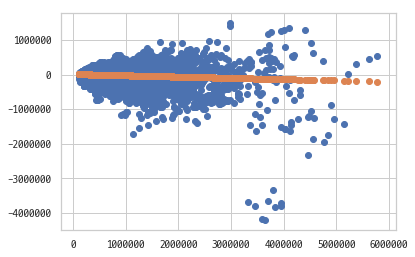

In [291]:
plt.scatter(x=X_test.values, y=y_test)
plt.scatter(x=X_test.values, y=y_pred)
plt.show()

In [284]:
np.sqrt(mean_squared_error(y_pred, y_test))

1103259.7866817715

In [285]:
# meta_linear = LinearRegression()
# meta_lgbm = LGBMRegressor()
# meta_xgb = XGBRegressor()

pipeline_1 = Pipeline([('poly', PolynomialFeatures(degree=1)), ('linear', LinearRegression())])
pipeline_2 = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression())])
pipeline_3 = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression())])
pipeline_4 = Pipeline([('poly', PolynomialFeatures(degree=4)), ('linear', LinearRegression())])
pipeline_5 = Pipeline([('poly', PolynomialFeatures(degree=5)), ('linear', LinearRegression())])
pipeline_6 = Pipeline([('poly', PolynomialFeatures(degree=6)), ('linear', LinearRegression())])
pipeline_7 = Pipeline([('poly', PolynomialFeatures(degree=7)), ('linear', LinearRegression())])


models = [pipeline_1, pipeline_2, pipeline_3, pipeline_4, pipeline_5, pipeline_6, pipeline_7]

scores = get_scores(models, meta_train, meta_label, rmse_=False)

In [286]:
scores

,RMSLE,R2 score
2,1.117989e+06,0.0193
7,1.118736e+06,0.0182
6,1.119281e+06,0.0166
5,1.119971e+06,0.0149
4,1.120585e+06,0.0136
3,1.122662e+06,0.0096
1,1.139480e+06,-0.0150


## LGBM best model

In [52]:
lgbm = LGBMRegressor(n_estimators=900,
                     max_depth=7,
                     learning_rate=0.035)

In [53]:
lgbm.fit(train, label)
y_pred = lgbm.predict(X_sub)
y_pred

array([13.13494496, 13.10383562, 14.08974416, ..., 13.08982018,
       12.6919973 , 12.97130319])

In [54]:
submission = LetSubmit(np.expm1(y_pred), "lgbm_test")
submission.head()

,id,price
0,15035,4.942906e+05
1,15036,4.744508e+05
2,15037,1.256917e+06
3,15038,3.068664e+05
4,15039,2.861011e+05


> Submission : 110482

### Bias 더하기 (7412)

In [98]:
lgbm = LGBMRegressor(n_estimators=900,
                     max_depth=7,
                     learning_rate=0.035)

In [99]:
lgbm.fit(train, label)
y_pred = lgbm.predict(X_sub)
y_pred

array([13.13494496, 13.10383562, 14.08974416, ..., 13.08982018,
       12.6919973 , 12.97130319])

In [100]:
y_pred = np.expm1(y_pred) + 7412
y_pred

array([ 513741.53059298,  498232.41378685, 1322933.08052284, ...,
        491401.31673186,  332546.49962948,  437308.9743007 ])

In [101]:
submission = LetSubmit(y_pred, "tune_lgbm_bias")
submission.head()

,id,price
0,15035,5.137415e+05
1,15036,4.982324e+05
2,15037,1.322933e+06
3,15038,3.031602e+05
4,15039,3.361485e+05


> Submission : 110167

### `y_pred`가 1000000 이상인 집들은 46076 Bias 더하기

In [335]:
lgbm = LGBMRegressor(n_estimators=900,
                     max_depth=7,
                     learning_rate=0.035)

In [336]:
lgbm.fit(train, label)
y_pred = lgbm.predict(X_sub)
y_pred

array([13.13494496, 13.10383562, 14.08974416, ..., 13.08982018,
       12.6919973 , 12.97130319])

In [337]:
y_pred = np.expm1(y_pred) + 7412
y_pred

array([ 513741.53059298,  498232.41378685, 1322933.08052284, ...,
        491401.31673186,  332546.49962948,  437308.9743007 ])

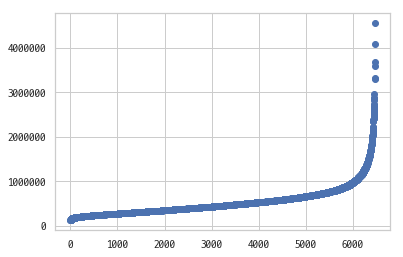

In [344]:
plt.scatter(x=range(len(y_pred)), y=sorted(y_pred))
plt.show()

In [338]:
np.mean(y_pred)

537716.743279088

In [342]:
len(y_pred > 4000000)

6468

In [320]:
y_pred = np.array([i + 46076 if i > 1000000 else i for i in y_pred])
y_pred

array([ 513741.53059298,  498232.41378685, 1369009.08052284, ...,
        491401.31673186,  332546.49962948,  437308.9743007 ])

In [321]:
np.mean(y_pred)

540851.1650477955

In [322]:
submission = LetSubmit(y_pred, "tune_lgbm_bigbias")
submission.head()

,id,price
0,15035,5.137415e+05
1,15036,4.982324e+05
2,15037,1.369009e+06
3,15038,3.031602e+05
4,15039,3.361485e+05


> Submission : 110167